#Proposed and train 3-6 models
 - Compare the model performance using RMSE between the fitted Y and actual Y in testing period

Team META
* Akhilesh Dongre
* Krishnanand Jha
* Janhvi Shah
* Manav Malavia
* Jaimeen Unagar



## Importing libraries

In [ ]:
import pandas as pd
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import math
import xgboost as xgb
from sklearn.linear_model import Lasso
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

pd.set_option("display.max_columns", None)
plt.rcParams["figure.figsize"] = (15, 20)

In [ ]:
start_date = datetime(2022, 1, 1)
end_date = datetime(2023, 12, 31)
META_STOCK = yf.download("META", start_date, end_date)
META_STOCK.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-03,338.299988,341.079987,337.190002,338.540009,338.181183,14537900
2022-01-04,339.950012,343.089996,331.869995,336.529999,336.173309,15998000
2022-01-05,333.019989,335.760010,323.839996,324.170013,323.826416,20564500
2022-01-06,322.820007,339.170013,322.720001,332.459991,332.107635,27962800
2022-01-07,332.739990,337.000000,328.880005,331.790009,331.438354,14722000


## Train & Test Data Split

In [ ]:

meta = pd.read_csv("/content/META_feature_mart (3).csv")
meta.set_index("Date", inplace=True)
meta.drop(columns=["Unnamed: 0"], inplace=True)
meta.drop(columns=["Date.1"], inplace=True)

meta.index = pd.to_datetime(meta.index)
meta = meta[meta.index >= pd.to_datetime("2022-01-01")]
split_date = pd.to_datetime("2023-07-31")

df_train = meta[meta.index <= split_date]
df_test = meta[meta.index > split_date]

print(f"Number of rows in df_train: {len(df_train)}")
print(f"Number of rows in df_test: {len(df_test)}")

columns_to_keep = []
columns_to_drop = ["Open", "High", "Low", "Typical_Price", "Adj Close"]

X_train = df_train.loc[:, df_train.columns != "Close"][:-1]
X_train = X_train.drop(columns_to_drop, axis=1)
y_train = df_train["Close"].shift(-1)[:-1]

X_test = df_test.loc[:, df_test.columns != "Close"][:-1]
X_test = X_test.drop(columns_to_drop, axis=1)
y_test = df_test["Close"].shift(-1)[:-1]

Number of rows in df_train: 395
Number of rows in df_test: 127


## Trading Function

In [ ]:
def merge_results(y_test, y_pred, META_STOCK):
    y_test = y_test.to_frame(name="Actual")
    y_test = y_test.rename_axis("Date")

    y_pred = pd.Series(y_pred, index=y_test.index)
    y_pred = y_pred.to_frame(name="Predicted")
    y_pred = y_pred.rename_axis("Date")

    results = META_STOCK.merge(y_test, left_index=True, right_index=True, how="inner")
    results = results.merge(y_pred, left_index=True, right_index=True, how="inner")
    results = results[["Actual", "Predicted", "Open", "Close"]]

    return results



- **Strategy Overview:**
  - The trading algorithm evaluates predicted and actual closing prices of stocks to make buy and sell decisions.

- **Buy Decision:**
  - If the predicted closing price for the next day is higher than the actual closing price for the current day, the algorithm buys stocks.

- **Sell Decision:**
  - If the predicted closing price for the next day is lower than the actual closing price for the current day, and the algorithm already owns stocks, it sells them.

- **Algorithm Execution:**
  - The algorithm repeats this process for each day in the dataset, making buy or sell decisions based on the predicted versus actual price comparison.

In [ ]:
def execute_trade(result_df, among):
    signal = 0
    amount = 10000
    Amount = []
    balance = 0
    action = []
    portfolio = 0
    Portfolio = []
    stocks = 0
    Stocks = []
    log_df = []

    for i in range(len(result_df) - 1):
        if result_df["Predicted"][i + 1] > result_df["Actual"][i]:
            if signal == 0:
                action.append("Buy")
                stocks = int(amount / result_df["Actual"][i])
                balance = int(amount % result_df["Actual"][i])
                portfolio = stocks * result_df["Actual"][i]
                signal = 1
                amount = portfolio + balance
                info = {
                    "Date": result_df.index[i],
                    "Stock": result_df["Actual"][i],
                    "Action": action[i],
                    "Portfolio": round(portfolio, 2),
                    "Stocks": stocks,
                    "Balance_init": balance,
                    "Total($)": round(amount, 2),
                }
                log_df.append(info)
                Portfolio.append(round(portfolio, 5))
                Amount.append(round(amount, 0))
                Stocks.append(stocks)
            else:
                action.append("Bought-Holding")
                portfolio = stocks * result_df["Actual"][i]
                amount = portfolio + balance
                info = {
                    "Date": result_df.index[i],
                    "Stock": result_df["Actual"][i],
                    "Action": action[i],
                    "Portfolio": round(portfolio, 2),
                    "Stocks": stocks,
                    "Balance_init": balance,
                    "Total($)": round(amount, 2),
                }
                log_df.append(info)
                Portfolio.append(round(portfolio, 5))
                Amount.append(round(amount, 0))
                Stocks.append(stocks)

        elif result_df["Predicted"][i + 1] < result_df["Actual"][i]:
            if signal == 1:
                action.append("Sell")
                portfolio = stocks * result_df["Actual"][i]

                signal = 0
                stocks = 0
                amount = balance + portfolio
                portfolio = 0
                balance = 0
                info = {
                    "Date": result_df.index[i],
                    "Stock": result_df["Actual"][i],
                    "Action": action[i],
                    "Portfolio": round(portfolio, 2),
                    "Stocks": stocks,
                    "Balance_init": balance,
                    "Total($)": round(amount, 2),
                }
                log_df.append(info)
                Portfolio.append(round(portfolio, 5))
                Amount.append(round(amount, 0))
                Stocks.append(stocks)
            else:
                action.append("Price-Prediction-Already-Lower")
                info = {
                    "Date": result_df.index[i],
                    "Stock": result_df["Actual"][i],
                    "Action": action[i],
                    "Portfolio": round(portfolio, 2),
                    "Stocks": stocks,
                    "Balance_init": balance,
                    "Total($)": round(amount, 2),
                }
                log_df.append(info)
                Portfolio.append(round(portfolio, 5))
                Amount.append(round(amount, 0))
                Stocks.append(stocks)

    Strategy_Result = pd.DataFrame(
        {
            "Actual_Close_Price": result_df.Close[1:],
            "Predicted_Close_Price": result_df.Predicted[1:],
            "Date": result_df.index[1:],
            "Amount($)": Amount,
        }
    )

    tnx_log = pd.DataFrame(log_df)

    return tnx_log, Strategy_Result

## LASSO

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Set up a range of alpha values to test
alphas = [0, 0.0001, 0.0005, 0.001,
          0.005, 0.01, 0.05, 0.1,
          0.5, 1, 2, 2.5, 3,
          3.5, 4, 4.5, 5]


best_rmse = float('inf')  # Initialize with infinity
best_alpha = None
best_ypred = None

for alpha in alphas:
        lr = Lasso(alpha=alpha, max_iter=10000)
        lr.fit(X_train_scaled, y_train)

        y_pred = lr.predict(X_test_scaled)
        MSE = mean_squared_error(y_test, y_pred, squared=False)

        RMSE = math.sqrt(MSE)
        if RMSE < best_rmse:
          best_rmse = RMSE
          best_alpha = alpha
          best_ypred = y_pred

        print(f"Lasso- RMSE: {RMSE:.2f}")

print("Best RMSE:", best_rmse)
print("Corresponding alpha value:", best_alpha)

<ipython-input-7-1dded78af80b>:21: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lr.fit(X_train_scaled, y_train)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.080e+04, tolerance: 1.359e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Lasso- RMSE: 3.70
Lasso- RMSE: 3.70
Lasso- RMSE: 3.70
Lasso- RMSE: 3.70
Lasso- RMSE: 3.73
Lasso- RMSE: 3.75
Lasso- RMSE: 3.74
Lasso- RMSE: 3.66
Lasso- RMSE: 3.26
Lasso- RMSE: 3.06
Lasso- RMSE: 3.08
Lasso- RMSE: 3.08
Lasso- RMSE: 3.15
Lasso- RMSE: 3.28
Lasso- RMSE: 3.45
Lasso- RMSE: 3.65
Lasso- RMSE: 3.89
Best RMSE: 3.0642685422294624
Corresponding alpha value: 1


In [ ]:
# Initialize the Ridge model with the best alpha
best_lasso_model = Lasso(alpha=best_alpha)

# Fit the model to the scaled training data
best_lasso_model.fit(X_train_scaled, y_train)

# Get predictions using the best Ridge model
y_pred_best = best_lasso_model.predict(X_test_scaled)

### Retrive the best model


### Plot Actual and Predicted

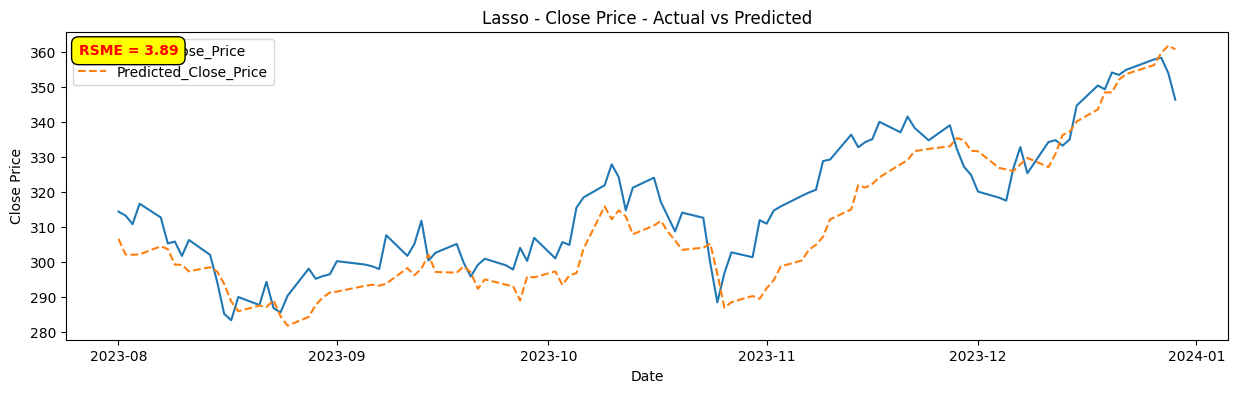

In [ ]:
actual_predict_merge_df = merge_results(y_test, y_pred_best, META_STOCK)
plt.figure(figsize=(15, 4))
plt.plot(actual_predict_merge_df['Actual'], label="Actual_Close_Price", linestyle="solid")
plt.plot(
    actual_predict_merge_df['Predicted'],
    label="Predicted_Close_Price",
    linestyle="dashed",
)
plt.title("Lasso - Close Price - Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.figtext(
    0.20,
    0.85,
    f"RSME = {RMSE:.2f}",
    ha="right",
    va="top",
    color="red",
    weight="bold",
    bbox=dict(facecolor="yellow", edgecolor="black", boxstyle="round,pad=0.5"),
)
plt.show()

### Trading Signals

In [ ]:
trade_txn_df, trade_txn_log_df = execute_trade(actual_predict_merge_df, 10000)
trade_txn_df

,Date,Stock,Action,Portfolio,Stocks,Balance_init,Total($)
0,2023-08-01,314.309998,Price-Prediction-Already-Lower,0.0,0,0,10000.0
1,2023-08-02,313.190002,Price-Prediction-Already-Lower,0.0,0,0,10000.0
2,2023-08-03,310.730011,Price-Prediction-Already-Lower,0.0,0,0,10000.0
3,2023-08-04,316.559998,Price-Prediction-Already-Lower,0.0,0,0,10000.0
4,2023-08-07,312.640015,Price-Prediction-Already-Lower,0.0,0,0,10000.0
...,...,...,...,...,...,...,...
100,2023-12-21,353.390015,Buy,10601.7,30,163,10764.7
101,2023-12-22,354.829987,Bought-Holding,10644.9,30,163,10807.9
102,2023-12-26,357.829987,Bought-Holding,10734.9,30,163,10897.9
103,2023-12-27,358.320007,Bought-Holding,10749.6,30,163,10912.6


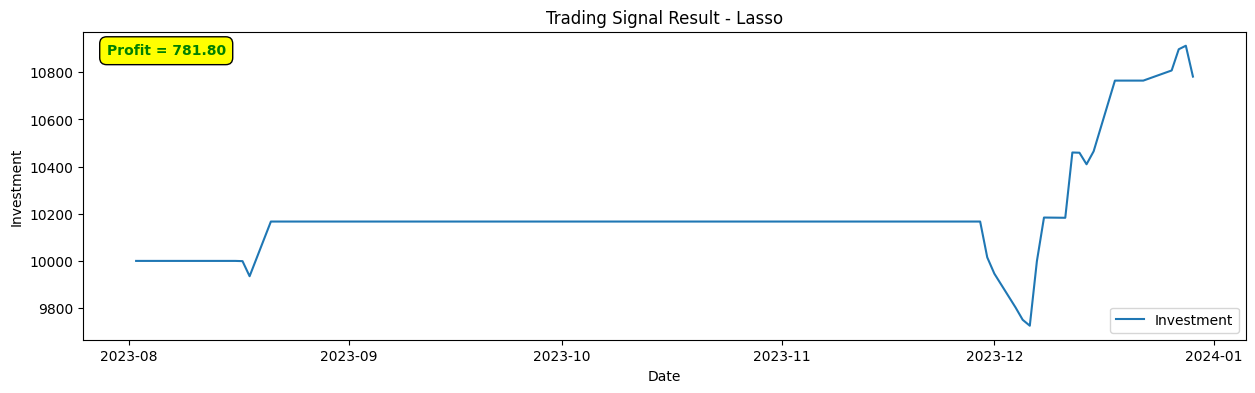

In [ ]:
plt.figure(figsize=(15, 4))
plt.plot(trade_txn_log_df["Amount($)"], label="Actual_Close_Price", linestyle="solid")
plt.title("Trading Signal Result - Lasso")
plt.xlabel("Date")
plt.ylabel("Investment")
plt.legend(labels = ['Investment'], loc='lower right')
plt.figtext(
    0.22,
    0.85,
    f"Profit = {trade_txn_df['Total($)'].iloc[-1]-10000:.2f}",
    ha="right",
    va="top",
    color="green",
    weight="bold",
    bbox=dict(facecolor="yellow", edgecolor="black", boxstyle="round,pad=0.5"),
)
plt.show()

## Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

alphas = [0.1, 0.5, 1.0, 1.5,
          2.0, 2.5, 5.0, 7.5, 10.0]

best_rmse = float('inf')  # Initialize with infinity
best_alpha = None
best_ypred = None

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, y_train)

    y_pred = ridge.predict(X_test_scaled)
    MSE = mean_squared_error(y_test, y_pred, squared=False)
    RMSE = math.sqrt(MSE)

    if RMSE < best_rmse:
        best_rmse = RMSE
        best_alpha = alpha
        best_ypred = y_pred

    print(f"Ridge - RMSE: {RMSE:.2f}")

print("Best RMSE:", best_rmse)
print("Corresponding alpha value:", best_alpha)

Ridge - RMSE: 3.69
Ridge - RMSE: 3.69
Ridge - RMSE: 3.69
Ridge - RMSE: 3.71
Ridge - RMSE: 3.72
Ridge - RMSE: 3.74
Ridge - RMSE: 3.86
Ridge - RMSE: 3.98
Ridge - RMSE: 4.09
Best RMSE: 3.688943971588405
Corresponding alpha value: 0.5


In [ ]:
# Initialize the Ridge model with the best alpha
best_ridge_model = Ridge(alpha=best_alpha)

# Fit the model to the scaled training data
best_ridge_model.fit(X_train_scaled, y_train)

# Get predictions using the best Ridge model
y_pred_best = best_ridge_model.predict(X_test_scaled)


### Retrive the best model

In [ ]:
# best_run_id = runs = client.search_runs(
#     experiment_ids=EXPERIMENT_ID,
#     run_view_type=ViewType.ACTIVE_ONLY,
#     max_results=1,
#     order_by=["metrics.RMSE ASC"],
#     filter_string="tags.model = 'Ridge'",
# )[0].info.run_id
# print(f"Best Run ID: {best_run_id}")

# loaded_model = mlflow.pyfunc.load_model(f"runs:/{best_run_id}/model")
# y_pred = loaded_model.predict(X_test_scaled)

MSE = mean_squared_error(y_test, y_pred, squared=False)
RMSE = math.sqrt(MSE)

print(f"Ridge - RMSE: {RMSE}")

Ridge - RMSE: 4.087343518940875


### Plot Actual and Predicted

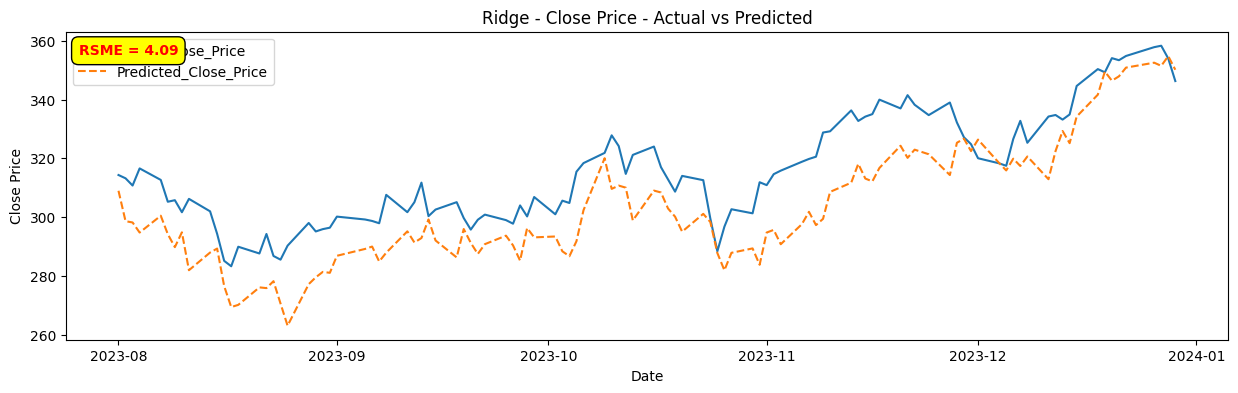

In [ ]:
actual_predict_merge_df = merge_results(y_test, y_pred_best, META_STOCK)
plt.figure(figsize=(15, 4))
plt.plot(actual_predict_merge_df['Actual'], label="Actual_Close_Price", linestyle="solid")
plt.plot(
    actual_predict_merge_df['Predicted'],
    label="Predicted_Close_Price",
    linestyle="dashed",
)
plt.title("Ridge - Close Price - Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.figtext(
    0.20,
    0.85,
    f"RSME = {RMSE:.2f}",
    ha="right",
    va="top",
    color="red",
    weight="bold",
    bbox=dict(facecolor="yellow", edgecolor="black", boxstyle="round,pad=0.5"),
)
plt.show()

### Trading Signal

In [ ]:
trade_txn_df, trade_txn_log_df = execute_trade(actual_predict_merge_df, 10000)
trade_txn_df

,Date,Stock,Action,Portfolio,Stocks,Balance_init,Total($)
0,2023-08-01,314.309998,Price-Prediction-Already-Lower,0.0,0,0,10000.00
1,2023-08-02,313.190002,Price-Prediction-Already-Lower,0.0,0,0,10000.00
2,2023-08-03,310.730011,Price-Prediction-Already-Lower,0.0,0,0,10000.00
3,2023-08-04,316.559998,Price-Prediction-Already-Lower,0.0,0,0,10000.00
4,2023-08-07,312.640015,Price-Prediction-Already-Lower,0.0,0,0,10000.00
...,...,...,...,...,...,...,...
100,2023-12-21,353.390015,Price-Prediction-Already-Lower,0.0,0,0,10240.29
101,2023-12-22,354.829987,Price-Prediction-Already-Lower,0.0,0,0,10240.29
102,2023-12-26,357.829987,Price-Prediction-Already-Lower,0.0,0,0,10240.29
103,2023-12-27,358.320007,Price-Prediction-Already-Lower,0.0,0,0,10240.29


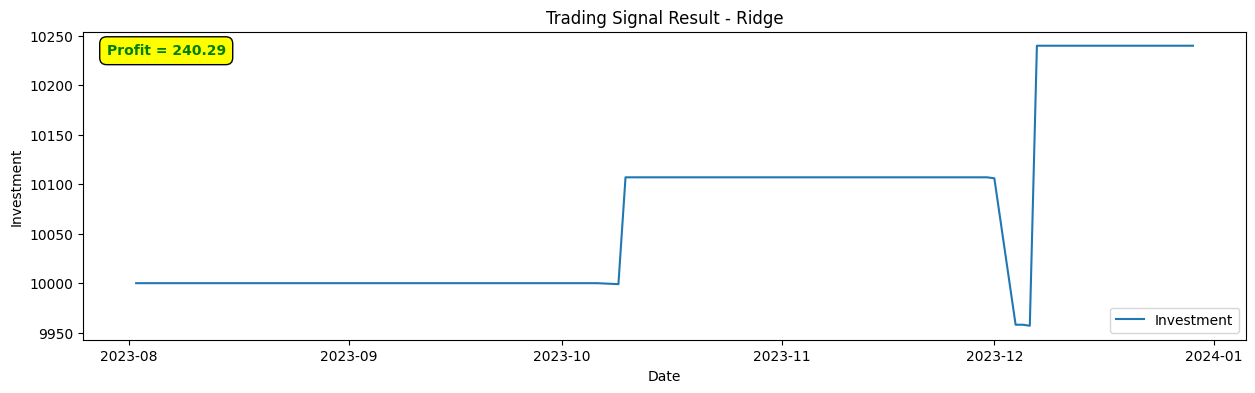

In [ ]:
plt.figure(figsize=(15, 4))
plt.plot(trade_txn_log_df["Amount($)"], label="Actual_Close_Price", linestyle="solid")
plt.title("Trading Signal Result - Ridge")
plt.xlabel("Date")
plt.ylabel("Investment")
plt.legend(labels = ['Investment'], loc='lower right')
plt.figtext(
    0.22,
    0.85,
    f"Profit = {trade_txn_df['Total($)'].iloc[-1]-10000:.2f}",
    ha="right",
    va="top",
    color="green",
    weight="bold",
    bbox=dict(facecolor="yellow", edgecolor="black", boxstyle="round,pad=0.5"),
)
plt.show()

## Extreme Gradient Boosting (XGBoost) Regressors


In [ ]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_test, label=y_test)

def objective(params):
      booster = xgb.train(
          params=params,
          dtrain=train,
          num_boost_round=1000,
          evals=[(valid, "validation")],
          early_stopping_rounds=50,
      )
      y_pred = booster.predict(valid)
      MSE = mean_squared_error(y_test, y_pred, squared=False)
      RMSE = math.sqrt(MSE)
      return {"loss": RMSE, "status": STATUS_OK}

### Retrive the best model


In [ ]:

MSE = mean_squared_error(y_test, y_pred, squared=False)
RMSE = math.sqrt(MSE)

print(f"XGBoost - RMSE: {RMSE}")

XGBoost - RMSE: 4.087343518940875


### Plot Actual and Predicted

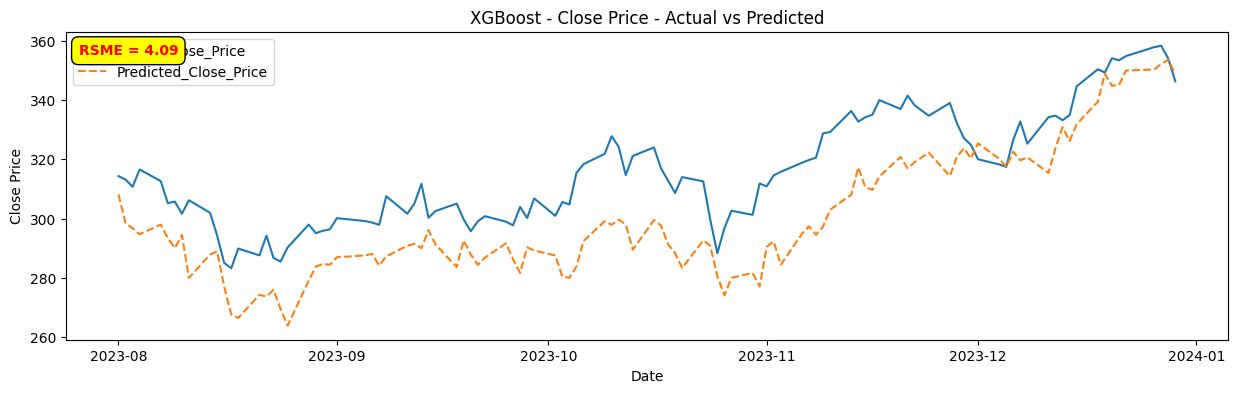

In [ ]:
actual_predict_merge_df = merge_results(y_test, y_pred, META_STOCK)
plt.figure(figsize=(15, 4))
plt.plot(actual_predict_merge_df['Actual'], label="Actual_Close_Price", linestyle="solid")
plt.plot(
    actual_predict_merge_df['Predicted'],
    label="Predicted_Close_Price",
    linestyle="dashed",
)
plt.title("XGBoost - Close Price - Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.figtext(
    0.20,
    0.85,
    f"RSME = {RMSE:.2f}",
    ha="right",
    va="top",
    color="red",
    weight="bold",
    bbox=dict(facecolor="yellow", edgecolor="black", boxstyle="round,pad=0.5"),
)
plt.show()

### Trading Signal

In [ ]:
trade_txn_df, trade_txn_log_df = execute_trade(actual_predict_merge_df, 10000)
trade_txn_df

,Date,Stock,Action,Portfolio,Stocks,Balance_init,Total($)
0,2023-08-01,314.309998,Price-Prediction-Already-Lower,0.0,0,0,10000.0
1,2023-08-02,313.190002,Price-Prediction-Already-Lower,0.0,0,0,10000.0
2,2023-08-03,310.730011,Price-Prediction-Already-Lower,0.0,0,0,10000.0
3,2023-08-04,316.559998,Price-Prediction-Already-Lower,0.0,0,0,10000.0
4,2023-08-07,312.640015,Price-Prediction-Already-Lower,0.0,0,0,10000.0
...,...,...,...,...,...,...,...
100,2023-12-21,353.390015,Price-Prediction-Already-Lower,0.0,0,0,10077.7
101,2023-12-22,354.829987,Price-Prediction-Already-Lower,0.0,0,0,10077.7
102,2023-12-26,357.829987,Price-Prediction-Already-Lower,0.0,0,0,10077.7
103,2023-12-27,358.320007,Price-Prediction-Already-Lower,0.0,0,0,10077.7


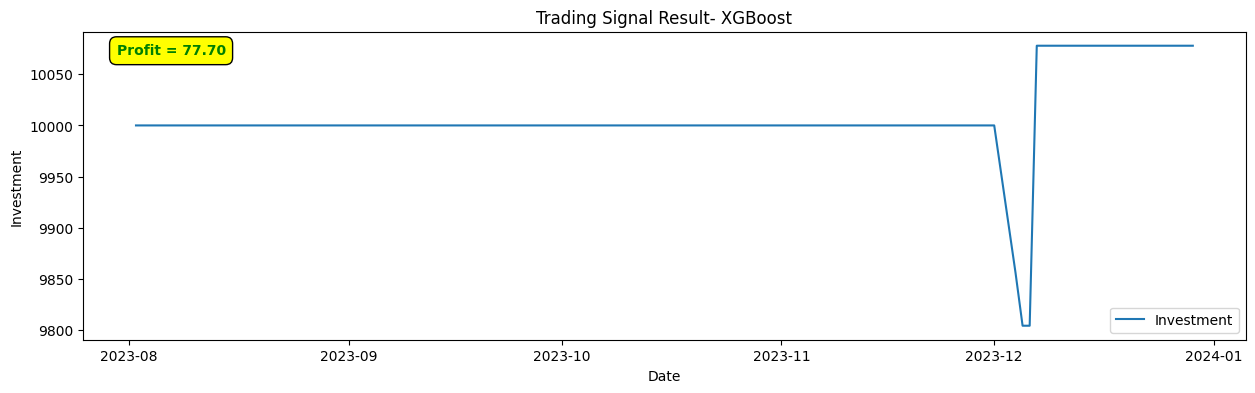

In [ ]:
plt.figure(figsize=(15, 4))
plt.plot(trade_txn_log_df["Amount($)"], label="Actual_Close_Price", linestyle="solid")
plt.title("Trading Signal Result- XGBoost")
plt.xlabel("Date")
plt.ylabel("Investment")
plt.legend(labels = ['Investment'], loc='lower right')
plt.figtext(
    0.22,
    0.85,
    f"Profit = {trade_txn_df['Total($)'].iloc[-1]-10000:.2f}",
    ha="right",
    va="top",
    color="green",
    weight="bold",
    bbox=dict(facecolor="yellow", edgecolor="black", boxstyle="round,pad=0.5"),
)
plt.show()

## Random Forest Regressors

### Retrive the best model


In [ ]:
from itertools import product

# Define the hyperparameters to tune
param_grid = {
    "n_estimators": [10, 15,20, 50],
    "max_depth": [5, 10, 15],
    "min_samples_leaf": [1, 2, 4],
}

# Loop through all combinations of hyperparameters
best_rmse = float('inf')  # Initialize with infinity
best_hyperparameters = {}

for n_estimators in param_grid["n_estimators"]:
    for max_depth in param_grid["max_depth"]:
        for min_samples_leaf in param_grid["min_samples_leaf"]:
            # Create the model with specific parameters
            model = RandomForestRegressor(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_leaf=min_samples_leaf,
            )

            # Fit the model and make predictions
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            # Calculate RMSE
            MSE = mean_squared_error(y_test, y_pred, squared=False)
            RMSE = math.sqrt(MSE)

            # Check if current RMSE is the best so far
            if RMSE < best_rmse:
                best_rmse = RMSE
                best_hyperparameters = {
                    "n_estimators": n_estimators,
                    "max_depth": max_depth,
                    "min_samples_leaf": min_samples_leaf
                }

            print(f"RandomForestRegressor - RMSE: {RMSE:.2f}")

print("Best Hyperparameters:", best_hyperparameters)
print("Best RMSE:", best_rmse)

RandomForestRegressor - RMSE: 7.11
RandomForestRegressor - RMSE: 6.99
RandomForestRegressor - RMSE: 7.07
RandomForestRegressor - RMSE: 6.77
RandomForestRegressor - RMSE: 6.82
RandomForestRegressor - RMSE: 6.58
RandomForestRegressor - RMSE: 7.25
RandomForestRegressor - RMSE: 6.76
RandomForestRegressor - RMSE: 6.99
RandomForestRegressor - RMSE: 6.79
RandomForestRegressor - RMSE: 6.66
RandomForestRegressor - RMSE: 6.98
RandomForestRegressor - RMSE: 7.35
RandomForestRegressor - RMSE: 6.84
RandomForestRegressor - RMSE: 7.28
RandomForestRegressor - RMSE: 7.61
RandomForestRegressor - RMSE: 7.28
RandomForestRegressor - RMSE: 7.05
RandomForestRegressor - RMSE: 6.92
RandomForestRegressor - RMSE: 6.71
RandomForestRegressor - RMSE: 6.90
RandomForestRegressor - RMSE: 6.96
RandomForestRegressor - RMSE: 7.33
RandomForestRegressor - RMSE: 7.07
RandomForestRegressor - RMSE: 7.21
RandomForestRegressor - RMSE: 7.19
RandomForestRegressor - RMSE: 7.24
RandomForestRegressor - RMSE: 6.93
RandomForestRegresso

In [ ]:
best_model = RandomForestRegressor(
    n_estimators=best_hyperparameters["n_estimators"],
    max_depth=best_hyperparameters["max_depth"],
    min_samples_leaf=best_hyperparameters["min_samples_leaf"]
)

best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)

### Plot Actual and Predicted

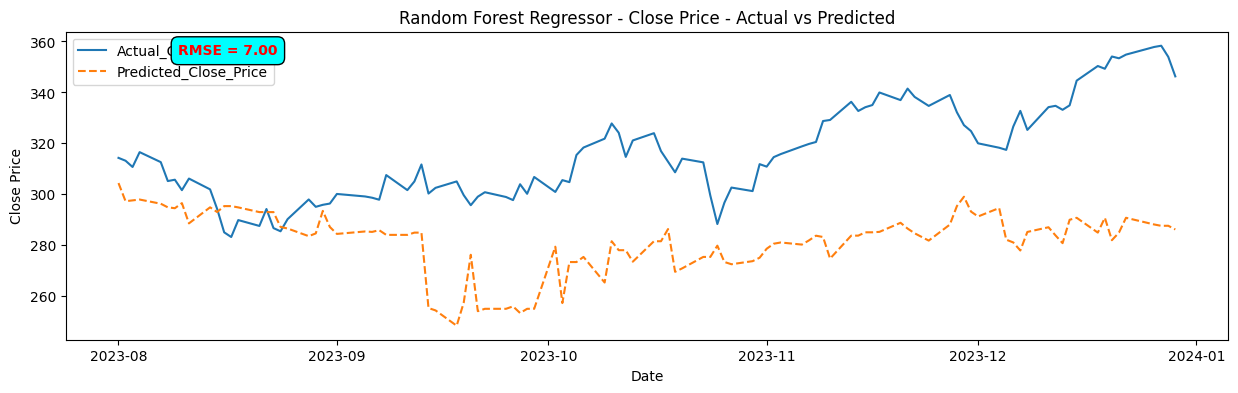

In [ ]:
actual_predict_merge_df = merge_results(y_test, y_pred_best, META_STOCK)
plt.figure(figsize=(15, 4))
plt.plot(actual_predict_merge_df['Actual'], label="Actual_Close_Price", linestyle="solid")
plt.plot(
    actual_predict_merge_df['Predicted'],
    label="Predicted_Close_Price",
    linestyle="dashed",
)
plt.title("Random Forest Regressor - Close Price - Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.figtext(
    0.20,
    0.85,
    f"RMSE = {RMSE:.2f}",
    ha="left",
    va="top",
    color="red",
    weight="bold",
    bbox=dict(facecolor="cyan", edgecolor="black", boxstyle="round,pad=0.5"),
)
plt.show()

### Trading Signals

In [ ]:
trade_txn_df, trade_txn_log_df = execute_trade(actual_predict_merge_df, 10000)
trade_txn_df

,Date,Stock,Action,Portfolio,Stocks,Balance_init,Total($)
0,2023-08-01,314.309998,Price-Prediction-Already-Lower,0.0,0,0,10000.00
1,2023-08-02,313.190002,Price-Prediction-Already-Lower,0.0,0,0,10000.00
2,2023-08-03,310.730011,Price-Prediction-Already-Lower,0.0,0,0,10000.00
3,2023-08-04,316.559998,Price-Prediction-Already-Lower,0.0,0,0,10000.00
4,2023-08-07,312.640015,Price-Prediction-Already-Lower,0.0,0,0,10000.00
...,...,...,...,...,...,...,...
100,2023-12-21,353.390015,Price-Prediction-Already-Lower,0.0,0,0,10116.84
101,2023-12-22,354.829987,Price-Prediction-Already-Lower,0.0,0,0,10116.84
102,2023-12-26,357.829987,Price-Prediction-Already-Lower,0.0,0,0,10116.84
103,2023-12-27,358.320007,Price-Prediction-Already-Lower,0.0,0,0,10116.84


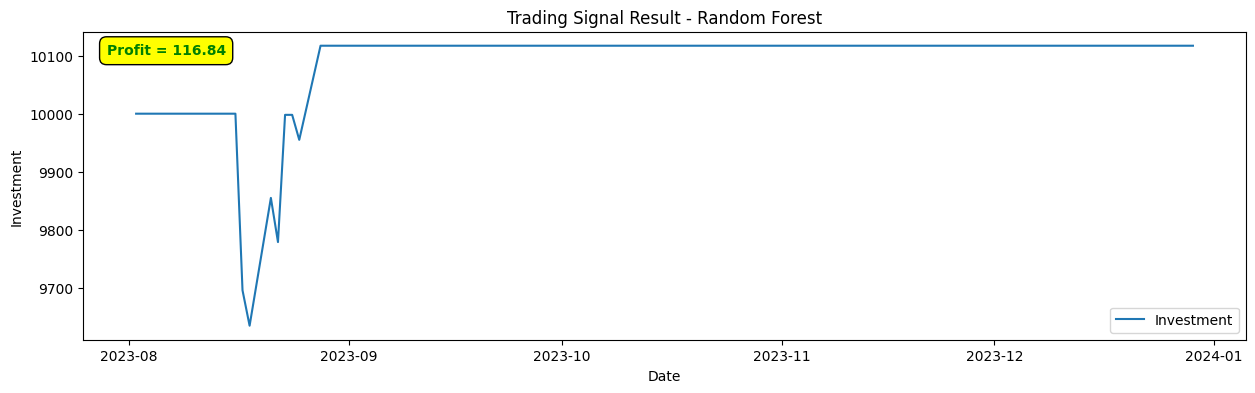

In [ ]:
plt.figure(figsize=(15, 4))
plt.plot(trade_txn_log_df["Amount($)"], label="Actual_Close_Price", linestyle="solid")
plt.title("Trading Signal Result - Random Forest")
plt.xlabel("Date")
plt.ylabel("Investment")
plt.legend(labels = ['Investment'], loc='lower right')
plt.figtext(
    0.22,
    0.85,
    f"Profit = {trade_txn_df['Total($)'].iloc[-1]-10000:.2f}",
    ha="right",
    va="top",
    color="green",
    weight="bold",
    bbox=dict(facecolor="yellow", edgecolor="black", boxstyle="round,pad=0.5"),
)
plt.show()